In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from math import floor
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, sum, count
from pyspark.sql.types import IntegerType, StructType, StructField, BooleanType, StringType, DoubleType, LongType

In [2]:
spark = (SparkSession
         .builder
         .appName("PRJCT_MelAubets")
         .config('spark.executor.memory', '4g')
         .config('spark.executor.cores', '8')
         .getOrCreate())

sc = spark.sparkContext

In [3]:
bicing_status1 = spark.read.options(header='True', inferSchema='True').csv('Projecte/estat_estacions/2021_01_Gener_BicingNou_ESTACIONS.csv')
bicing_status = spark.read.options(header='True', Schema = bicing_status1.schema).csv('Projecte/estat_estacions')
bicing_info = spark.read.json('Projecte/station_information.json')
post_population = spark.read.options(header='True', inferSchema='True', delimiter=';').csv('Projecte/postalcat.csv')

bs = bicing_status.count()
bi = bicing_info.count()
si = (bs/bi)

bicing_status.printSchema()
print("Hi ha %d actualitzacions d'estat en total" %bs)
print("Hi ha %d estacions" %bi)
print("Hi ha %d actualitzacions per estació" %si)

root
 |-- station_id: string (nullable = true)
 |-- num_bikes_available: string (nullable = true)
 |-- num_bikes_available_types.mechanical: string (nullable = true)
 |-- num_bikes_available_types.ebike: string (nullable = true)
 |-- num_docks_available: string (nullable = true)
 |-- last_reported: string (nullable = true)
 |-- is_charging_station: string (nullable = true)
 |-- status: string (nullable = true)
 |-- is_installed: string (nullable = true)
 |-- is_renting: string (nullable = true)
 |-- is_returning: string (nullable = true)
 |-- last_updated: string (nullable = true)
 |-- ttl: string (nullable = true)

Hi ha 48450466 actualitzacions d'estat en total
Hi ha 505 estacions
Hi ha 95941 actualitzacions per estació


In [4]:
bicing_status = bicing_status.groupBy('station_id').agg(avg('num_bikes_available').alias('num_bikes_available'))
bicing = bicing_status.join(bicing_info, ['station_id']).orderBy('station_id')

print("Esquema bicing:\n")
bicing.printSchema()

Esquema bicing:

root
 |-- station_id: string (nullable = true)
 |-- num_bikes_available: double (nullable = true)
 |-- num_docks_available: double (nullable = true)
 |-- address: string (nullable = true)
 |-- altitude: double (nullable = true)
 |-- capacity: long (nullable = true)
 |-- cross_street: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- name: string (nullable = true)
 |-- nearby_distance: double (nullable = true)
 |-- physical_configuration: string (nullable = true)
 |-- post_code: string (nullable = true)



In [5]:
rentable = bicing.select('station_id',
                         'name',
                         'num_bikes_available',
                         'capacity',
                         'post_code')

rentable = rentable.withColumn("ratio",
                               ((1-(col("num_bikes_available")/col("capacity"))))).withColumn("post_code", rentable['post_code'].cast(IntegerType()))

In [6]:
ren=rentable.filter("ratio >= 0.5").count()
noRen=rentable.count()-ren
mesRen=rentable.orderBy('ratio', ascending = False).first()
mesRenNom = mesRen.name
mesRenRatio = mesRen.ratio
menysRen=rentable.orderBy('ratio').first()
menysRenNom = menysRen.name
menysRenRatio = menysRen.ratio
    
print("\nSi es consideren rendibles aquelles estacions amb més d'un 50" +"%"+" de bicicletes utilitzades de mitjana:\
      \nHi ha %d estacions rendibles"%ren\
      + " i %d estacions no rendibles."%noRen)
print('\nL\'estació més rendible és la:%s'%mesRenNom + ' amb un %s'%mesRenRatio+'%'+" de bicicletes usades de mitjana")
print('\nL\'estació menys rendible és la:%s'%menysRenNom + ' amb un %s'%menysRenRatio+'%'+" de bicicletes usades de mitjana")


Si es consideren rendibles aquelles estacions amb més d'un 50% de bicicletes utilitzades de mitjana:      
Hi ha 412 estacions rendibles i 93 estacions no rendibles.

L'estació més rendible és la:C/ LLOBREGÓS, 115 amb un 0.9070498322206834% de bicicletes usades de mitjana

L'estació menys rendible és la:PL. JOAQUIM XIRAU I PALAU, 1 amb un 0.2525915963496568% de bicicletes usades de mitjana


In [7]:
rentable_zones = rentable.groupBy('post_code')\
                        .agg((sum('ratio')/count('post_code'))
                             .alias('rentable_ratio'))\
                        .orderBy('rentable_ratio', ascending = False)

a = int(rentable_zones.count()/2)
m_rentable_zones = rentable_zones.limit(a+1)
l_rentable_zones = rentable_zones.orderBy('rentable_ratio').limit(a)
print("\nEls deu districtes postals on les estacions son més rendibles son els següents:\n")
m_rentable_zones.limit(10).show()
print("\nEls deu districtes postals on les estacions son menys rendibles son els següents:\n")
l_rentable_zones.limit(10).show()


Els deu districtes postals on les estacions son més rendibles son els següents:

+---------+------------------+
|post_code|    rentable_ratio|
+---------+------------------+
|     8022| 0.863675165299612|
|     8023|0.8538471649190068|
|     8042|0.8389067044491677|
|     8006|0.8253970535673893|
|     8035|0.8228713662239416|
|     8034|0.8142623837704457|
|     8031|0.8073166819548427|
|     8021|0.8042107511431367|
|     8017|0.7943923542670357|
|     8016|0.7928681424709142|
+---------+------------------+


Els deu districtes postals on les estacions son menys rendibles son els següents:

+---------+-------------------+
|post_code|     rentable_ratio|
+---------+-------------------+
|     8930| 0.3999327766761839|
|     8039|0.41874030510298893|
|     8019|0.45585316610564053|
|     8002| 0.4808707605915257|
|     8001|  0.483718681754345|
|     8038| 0.4935458895792438|
|     8003| 0.5015208624620618|
|     8005| 0.5051067519346677|
|     8018| 0.5493721503180977|
|     8013| 0.5

In [8]:
stations_population = bicing.join(post_population, ['post_code'])

population = stations_population.groupBy('post_code','population')\
                    .agg((count('post_code')/col('population'))
                         .alias('ratio'))\
                    .orderBy('ratio', ascending = False)

max_z = population.first().ratio

population_zones = population.withColumn('population_ratio',(population['ratio']/max_z))\
            .select('post_code','population_ratio')\
            .orderBy('population_ratio')

m_population_zones = population_zones.limit(a+1)
l_population_zones = population_zones.orderBy('population_ratio', ascending = False).limit(a)
print("\nEls deu districtes postals amb menys estacions per població son els següents:\n")
m_population_zones.limit(10).show()
print("\nEls deu districtes postals amb més estacions per població son els següents:\n")
l_population_zones.limit(10).show()


Els deu districtes postals amb menys estacions per població son els següents:

+---------+--------------------+
|post_code|    population_ratio|
+---------+--------------------+
|    08040|0.004914438090200875|
|     8001| 0.04227888899421746|
|    08035|0.054142640364188165|
|    08038|  0.1107399214482416|
|    08022| 0.13268379755308468|
|    08039|  0.1563236296368416|
|    08033| 0.15701115536095403|
|    08004|  0.1814975583288117|
|    08023| 0.18673458706953702|
|    08032| 0.18884524005551506|
+---------+--------------------+


Els deu districtes postals amb més estacions per població son els següents:

+---------+-------------------+
|post_code|   population_ratio|
+---------+-------------------+
|    08002|                1.0|
|    08007| 0.8354993560473013|
|    08010| 0.8300569966267303|
|    08011| 0.8064289301858363|
|    08015| 0.6910137228862329|
|    08003| 0.6532623169107856|
|    08037| 0.5993012631013169|
|    08005| 0.5511740253904056|
|    08013| 0.5063336520076

In [9]:
bikes_needed = m_rentable_zones.join(m_population_zones, ['post_code'], "inner")\
                                .select('post_code','rentable_ratio','population_ratio')

print("\nA continuació es mostren els districtes postals en els que convindria construïr estacions:")
bikes_needed.show()


A continuació es mostren els districtes postals en els que convindria construïr estacions:
+---------+------------------+--------------------+
|post_code|    rentable_ratio|    population_ratio|
+---------+------------------+--------------------+
|     8035|0.8228713662239416|0.054142640364188165|
|     8022| 0.863675165299612| 0.13268379755308468|
|     8033|0.7213261817156337| 0.15701115536095403|
|     8023|0.8538471649190068| 0.18673458706953702|
|     8032|0.7777921779959808| 0.18884524005551506|
|     8017|0.7943923542670357| 0.18995756073074643|
|     8006|0.8253970535673893| 0.19317812669193288|
|     8034|0.8142623837704457| 0.23670680333034796|
|     8042|0.8389067044491677|  0.2626464872504564|
|     8024|0.7720508720527861|  0.2830602354027233|
|     8016|0.7928681424709142|   0.300944669365722|
|     8031|0.8073166819548427|   0.314239413795533|
|     8028|0.7551573413659856| 0.33711816224920715|
+---------+------------------+--------------------+



In [10]:
bikes_leftover = l_rentable_zones.join(l_population_zones, ['post_code'], "inner")\
                                .select('post_code','rentable_ratio','population_ratio')

print("A continuació es mostren els districtes postals en els que hi sobren estacions:")
bikes_leftover.show()

A continuació es mostren els districtes postals en els que hi sobren estacions:
+---------+------------------+-------------------+
|post_code|    rentable_ratio|   population_ratio|
+---------+------------------+-------------------+
|     8002|0.4808707605915257|                1.0|
|     8010|0.6386914998384332| 0.8300569966267303|
|     8011|0.6022215355491175| 0.8064289301858363|
|     8015|0.5909462325557184| 0.6910137228862329|
|     8003|0.5015208624620618| 0.6532623169107856|
|     8005|0.5051067519346677| 0.5511740253904056|
|     8013|0.5786848062259456| 0.5063336520076482|
|     8018|0.5493721503180977| 0.4770719002883453|
|     8001| 0.483718681754345| 0.4650677789363921|
|     8009|0.6396749609647617|0.43353584447144594|
|     8014|0.6425283776016352|  0.401259559154296|
|     8026|0.6145421112402386|0.35426950354609926|
+---------+------------------+-------------------+



In [11]:
stations_topanda = population_zones.join(rentable_zones, ['post_code'], 'inner')\
                                    .select('post_code','rentable_ratio','population_ratio')\
                                    .orderBy('rentable_ratio')
stations_panda = stations_topanda.toPandas()

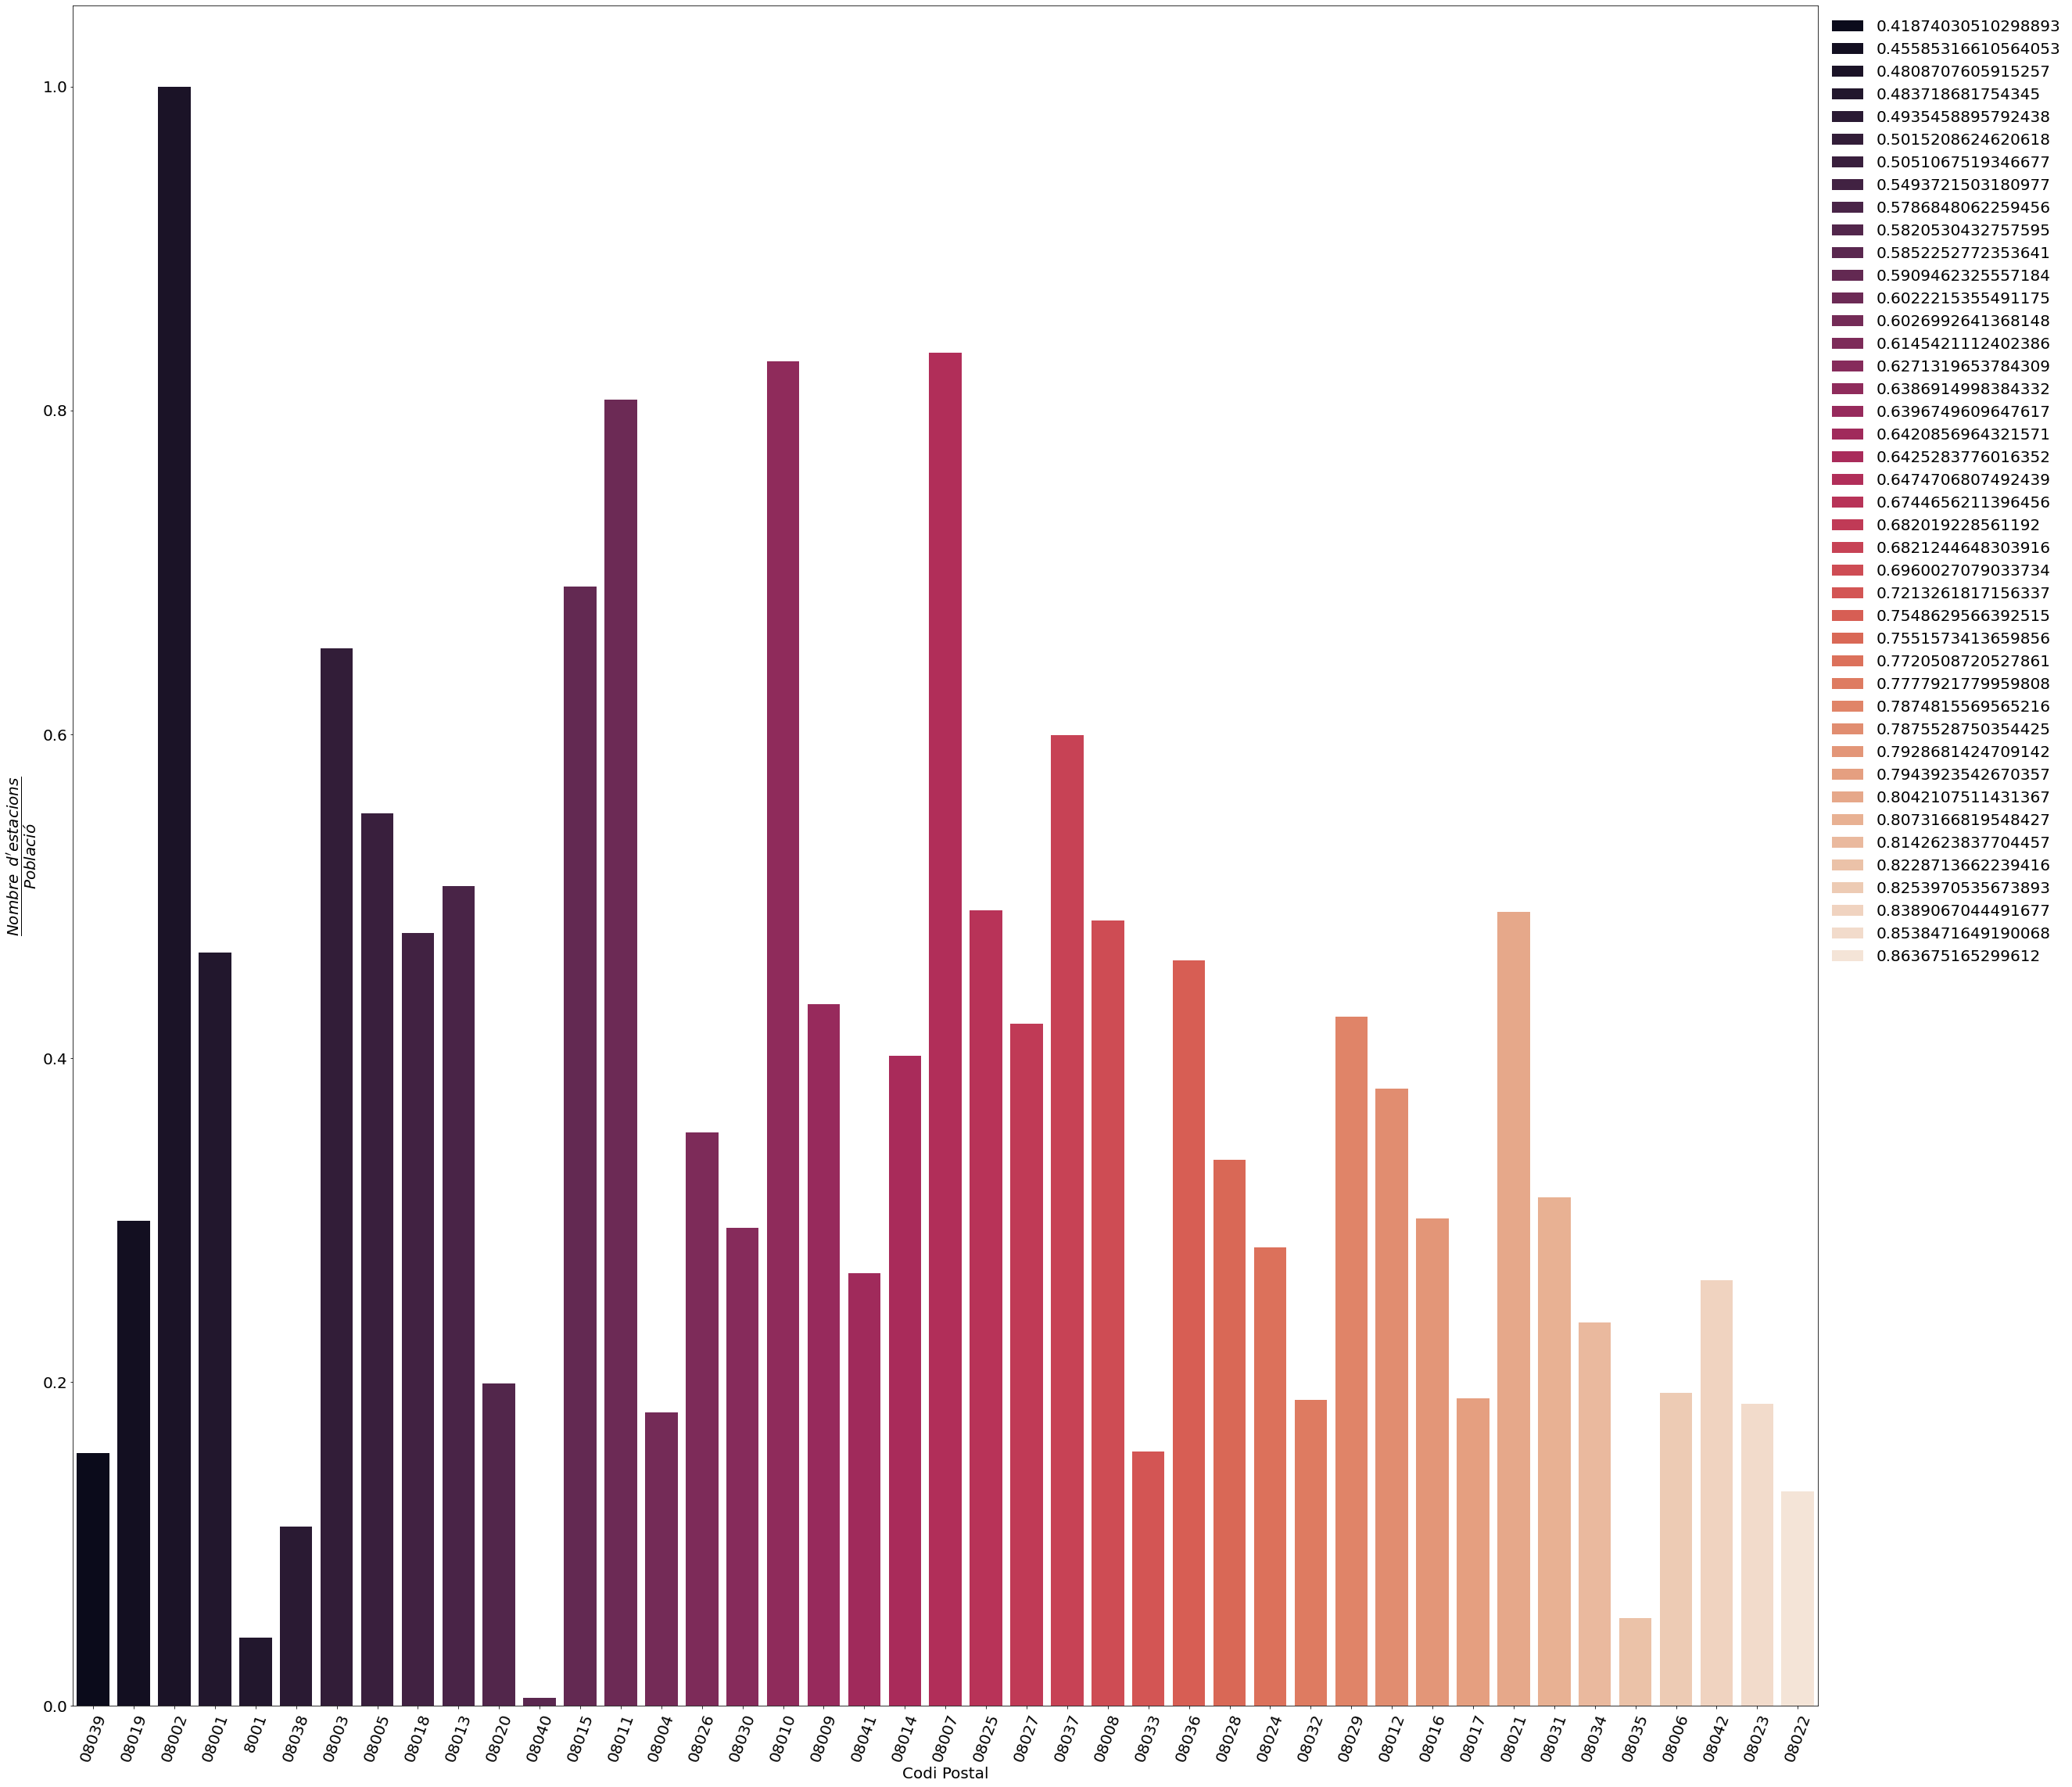

In [13]:
stations_graph = sns.barplot(x='post_code',
                             y='population_ratio',
                             hue='rentable_ratio',
                             dodge = False,
                               palette = 'rocket',
                            data = stations_panda)

plt.rcParams["figure.figsize"] = (40,40)
plt.xticks(fontsize = 20,rotation = 70)
plt.yticks(fontsize = 20)
plt.xlabel("Codi Postal", fontsize = 20)
plt.ylabel(r"$\dfrac{Nombre\hspace{0.5}d'estacions}{Població}$", fontsize = 20)
plt.legend(fancybox=True, framealpha=0, fontsize = 20,bbox_to_anchor=(1, 1))
plt.savefig('stations_graph.png')
plt.show(stations_graph)
